# Import Packages

In [3]:
import pandas as pd
import os
import numpy as np

#Own packages
import louvainFunctions as lF
import gmm
import markergeneFunctions as mgF
import plotumapFunctions as puF
import evaluation as ev

# os.chdir(r'C:\Users\Asus\OneDrive\Documents\YEAR 1\ML\Project')

print(os.getcwd())
print(os.listdir())


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\Asus\\OneDrive\\Documents\\YEAR 1\\ML\\Project'

# Pre-process data and dimensionality reduction

Log transform and normalization, dimensionality reduction using PCA

In [ ]:
data = np.loadtxt("../output/data_loaded.csv", dtype=float, delimiter=",")
data[data == 0.0] = 0.0000001
print("Data is loaded. Now taking log-transform. ")

data = log_transform(data)
print("Data is transformed. Now scaling.")

data = scale(data)
print("Data is mean-centred. Now performing PCA.")

variances, reduced_data = perform_pca(data)
print("PCA successful! Now saving data.")

sample = reduced_data[:500, :]
np.savetxt("../output/reduced_sample_20_PCs.csv", sample, delimiter=",", fmt="%.2f")

np.savetxt("../output/reduced_data_20_PCs.csv", reduced_data, delimiter=",", fmt="%.2f")
print("Data saved! Now plotting.")

# Load Data

In [5]:
data = np.loadtxt(os.path.join(r'./data', 'reduced_sample_20_PCs.csv'), delimiter=',')
print(data.shape)

(500, 20)


# Run GMMs

# Test against GMMs from package

In [ ]:
from sklearn.mixture import GaussianMixture as gmm

membership_arr_package = GaussianMixture(n_components=2, random_state=0).fit_predict(data)

# Run Louvain
Will create an array of labels with dimensions (# of samples,)

In [11]:
membership_arr = lF.louvain_clustering(data, k=5)

Starting Louvain clustering


In [12]:
np.save('membership_arr_louvain.npy', membership_arr)

# Test against Louvain from package

In [5]:
import networkx as nx
import networkx.algorithms.community as nx_comm
import community as community_louvain

edge_list, edge_weights = lF.create_kNN_graph(data, 5)
G=nx.Graph()
G.add_edges_from(edge_list)

#first compute the best partition
partition = nx_comm.louvain_communities(G)

membership_arr_package = np.zeros((len(data)))
for i in range(len(partition)):
    for n in partition[i]:
        membership_arr_package[n] = i
        

# Plot UMAP

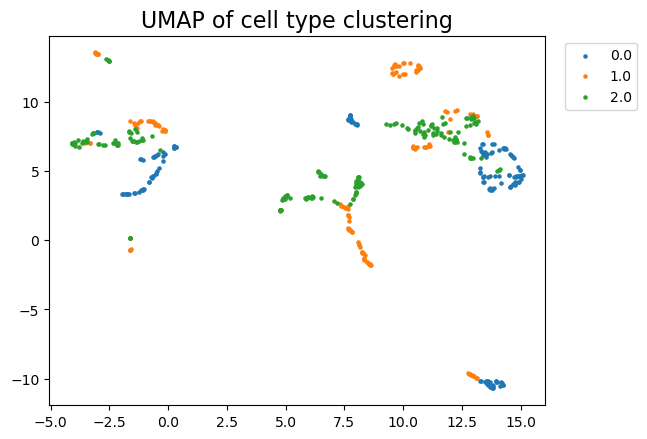

In [13]:
puF.plot_umap(data, membership_arr)

# Get Marker Genes and plot violin plots

Will save a dictonary of marker genes for each cluster and plot violin plots for top 3 genes for each cluster. Requires original data before dimension reduction. Have not tested on this dataset.

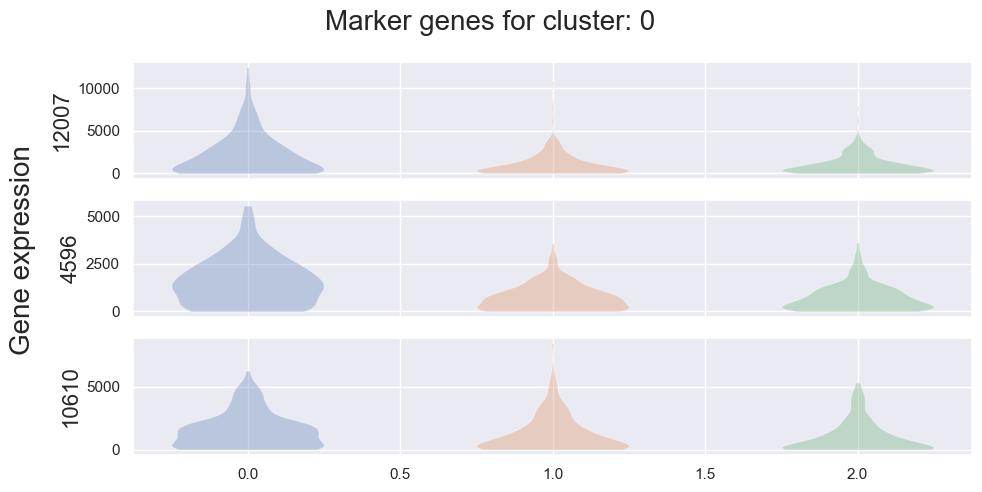

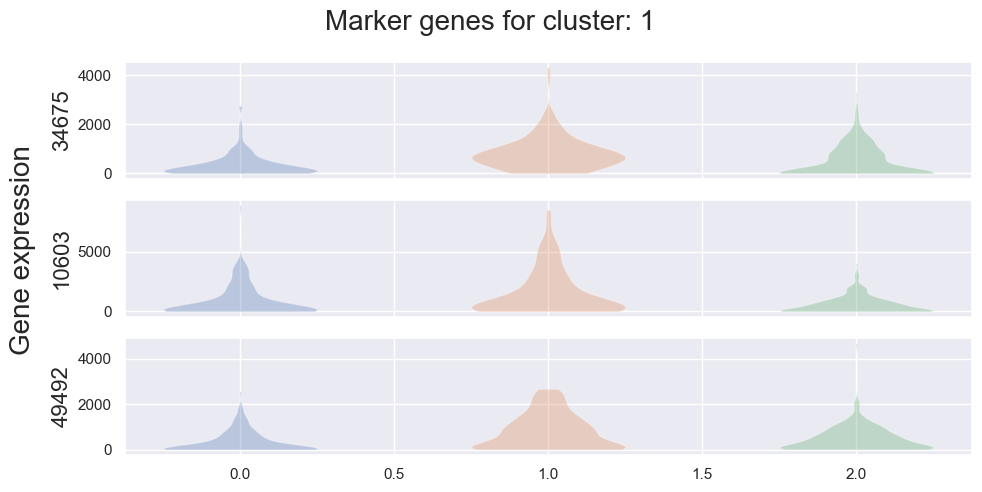

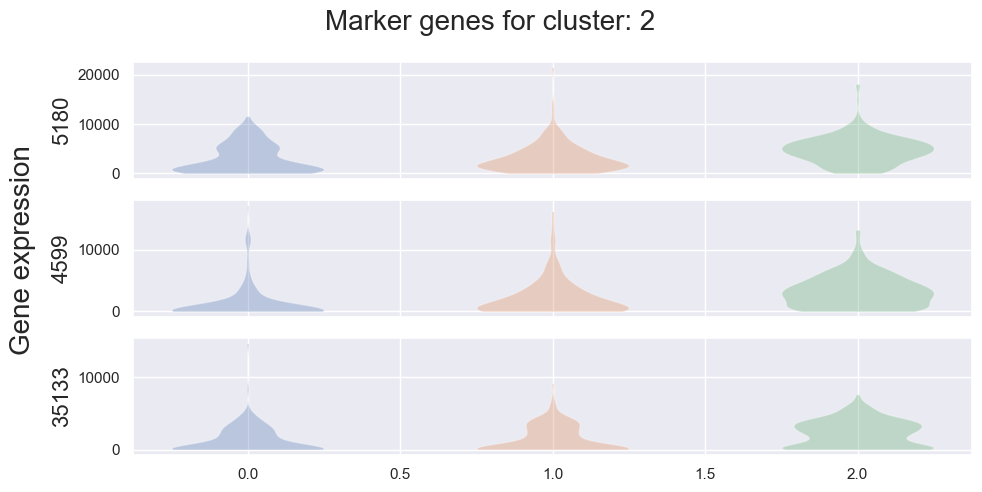

In [64]:
data_file = os.path.join(r'./data', 'data_mtg_loaded.hdf5')
clusters = np.unique(membership_arr)
median_arr, mean_arr = mgF.get_gene_stats_by_cluster(data_file, membership_arr.reshape(-1), clusters)
mgF.filter_genes_by_median(median_arr, mean_arr)
mgF.plot_marker_genes(data_file, clusters, membership_arr.reshape(-1),)

# Evaluate performance

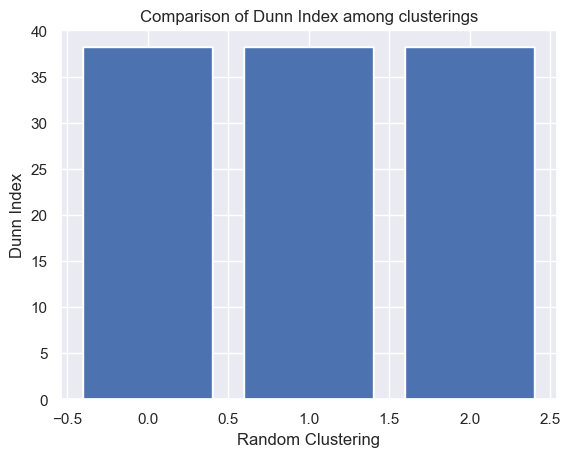

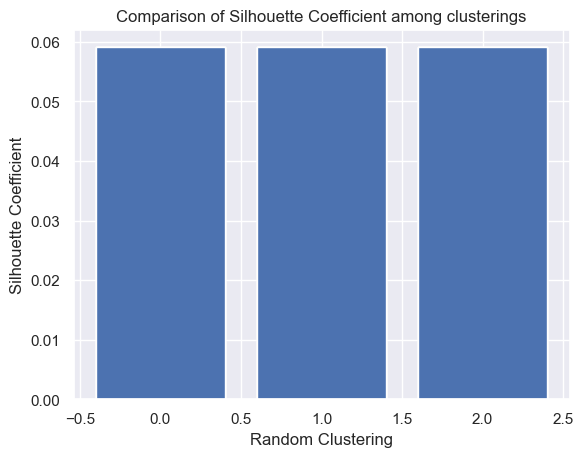

<Figure size 640x480 with 0 Axes>

In [63]:
import importlib
importlib.reload(ev)


centres = ev.calculate_cluster_centroids(membership_arr, data)

di = ev.dunn_index(membership_arr, data, centres)
sc = ev.silhouette_coefficient(membership_arr, data, centres)
        
ev.plot_evaluation_metric(di, membership_arr, "Dunn Index", "Random Clustering", './output')
ev.plot_evaluation_metric(
        sc, membership_arr, "Silhouette Coefficient", "Random Clustering", './output')